# Overvies of needed libraries and modules

- The main framework for working with graphs and predictions on them is [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/). It contains various methods for Deep Learning on graphs. 
- Torch is essential for Graph neural netowrks. We can use activation functions, normalization methods, 'Sequential' to stack layers from there.
- Sklearn can be used for metrics computing and for simple models applying (like PCA for plotting weights of models).
- Netoworkx and matplotlip will be used for data visualization.
- **We will not** use cuda to simplify the code. CPU is enough for training our models 

In [1]:
# !pip install torch_geometric

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import accuracy_score
import random
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


# Dataset Loading

To check the Exploratory Data Analysis check our [colab](https://colab.research.google.com/drive/1oWOgg17OvOMEKZwZkVvR9CHwdBU2L9F2?usp=sharing)


In [20]:
citeseer_dataset = Planetoid(root='./CiteseerData', name='Citeseer')
citeseer = citeseer_dataset[0]
print(f"Dataset: {citeseer_dataset}, Number of nodes: {citeseer.num_nodes}, Number of edges: {citeseer.num_edges}")

cora_dataset = Planetoid(root='./CoraData', name='Cora')
cora = cora_dataset[0]
print(f"Dataset: {cora_dataset}, Number of nodes: {cora.num_nodes}, Number of edges: {cora.num_edges}")


Dataset: Citeseer(), Number of nodes: 3327, Number of edges: 9104
Dataset: Cora(), Number of nodes: 2708, Number of edges: 10556


# Models

In this tutoral will be considered GCN and GAT models

### GCN

Graph Convolutional Networks - averages the normalised representation of the neighbours for a node.

1. A feature description $x_i$ for every node i is gotten
2. Descriptions are summarized in a $N×D$ feature matrix $X$ (N: number of nodes, D: number of input features)
3. A representative description of the graph structure in matrix form: **adjacency matrix A** (or some function)
4. $H^0 = X$
5. NN layer: $H^{(l+1)} = f(H^{(l)}, A)$ 
6. More details: $f(H^{(l)}, A) = \sigma(AH^{(l)}W^{(l)})$ where $W^{(l)}$ is a weight matrix for the l'th layer with learnable parameters and $\sigma$ - non-linear activation function (usually ReLU is used)
7. Improvement: $f(H^{(l)}, A) = \sigma(\hat{D}^{-0.5}\hat{A}\hat{D}^{-0.5}H^{(l)}W^{(l)})$
8. $Z = H^{(L)}$ matrix is produced ($N×F$ matrix where F - number of output features per node)

Vector form: $h_{v_i}^{(l+1)} = \sigma(\sum_{j}\frac{1}{c_{ij}}h_{v_j}^{(l)}W^{(l)})$ , where j - neighboring nodes and $c_{ij}$ - normalization constant


**Explanation**:
- $\hat{A} = A+I$: adding self-loops to take into accaunt node's information itself
- $\hat{D}$: diagonal node degree matric of $\hat{A}$. Frequently, A matrix is non-normalized, so in $AH^{(l)}W^{(l)}$ expression multiplying by A will scale the feature vectors a lot. We can avoid it by normalyzing A: make all rows sum to one ($\hat{D}^{-0.5}\hat{A}$). It can be interpreted as taking the average of neighboring node features.
- $\hat{D}^{-0.5}\hat{A}\hat{D}^{-0.5}$: adds even more complexity

The simplest GCN has only three different operators:
- Graph convolution
- Linear layer
- Nonlinear activation



In [27]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, activation='relu'):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

        # GCNConv already contains Linear layers, so there is no need to add them manually
        if activation == 'relu':
            self.activation = torch.nn.ReLU()
        else:
            raise Exception("Unsupportable type of activation function.")

    def forward(self, data):
        # usually data is fully passed to the forward
        # extract the required elements: 
        x, edge_index = data.x, data.edge_index

        # first convolution
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        # second convolution
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x


## GAT

Graph Attention Networks - learn to weigh the different neighbours based on their importance (like transformers). They enhance the functionality of GCNs by incorporating attention mechanisms to assign varying importance to neighbors when aggregating information for a node.

1. For each node $i$, a feature description $x_i$​ is obtained.
2. Descriptions of all nodes are summarized into an $N×D$ feature matrix $X$ (N: number of nodes, D: number of input features).
3. Graph structure is represented using the adjacency matrix A or a similar representation of connectivity.
4. $H^0=X$
5. At layer l: $H^{(l+1)} = concat(\sigma(\sum_{j ∈ N(i)}\alpha_{ij}H_j^{(l)}W^{(l)}))$ where $N(i)$ - i'th neighbours
6. $\alpha_{ij} = softmax_j(LeakyReLU(a^{⊤}(H_i^{(l)}W^{(l)}||H_j^{(l)}W^{(l)})))$ where $a$ - learnable attention vector and || = concatenation
7. $Z = H^{(L)}$

**Explanation**:
- GAT replaces the uniform aggregation of neighbors in GCN with an attention mechanism, allowing the model to learn which neighbors are more important for a given node
- Self-attention: each node computes scores for its neighbors, reflecting their relative importance in determining its representation
- Multi-head attention: GAT often uses multiple attention heads to stabilize learning and capture diverse patterns. The outputs from all heads are concatenated or averaged.

The simplest GAT also consists of three main operators:
- Graph attention
- Linear layer (with weights for attention)
- Nonlinear activation


In [32]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8, dropout=0.5):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.ELU()

    def forward(self, data):
        # in the same way extract elements
        x, edge_index = data.x, data.edge_index

        # 1st pass
        x = self.gat1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        # 2nd pass
        x = self.gat2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x


# Training and Evaluation methods

Since both datasets are imbalanced, we introduce weights assignment for each class. We use compute_class_weight method from the sklearn library. It computes classes weights: 

$$ weight_i​= \frac{​total samples​}{number of classes×samples in class_i}$$

Rule Lerning: $$weight_{Rule Learning} = \frac{2708}{7*180}≈2.15$$

Neural Networks:  $$weight_{NN} = \frac{2708}{7*818}≈0.48$$

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# default train :)
def train(model, data, optimizer, class_weights=None, epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        # compute loss only on train part of the dataset:
        train_part = data.train_mask
        labels = data.y
        if class_weights is not None:
            loss = F.nll_loss(out[train_part], labels[train_part], weight=class_weights)
        else:
            loss = F.nll_loss(out[train_part], labels[train_part])
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, loss: {loss.item():.4f}")

        losses.append(loss.item())
    return losses


In [35]:
# default evaluate
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    preds = model(data)
    preds = preds.argmax(dim=1)
    
    train_part = data.train_mask
    val_part = data.val_mask
    test_part = data.test_mask
    labels = data.y 

    acc_train = accuracy_score(labels[train_part], preds[train_part])
    acc_val = accuracy_score(labels[val_part], preds[val_part])
    acc_test = accuracy_score(labels[test_part], preds[test_part])
    
    return acc_train, acc_val, acc_test


# Pipeline for Cora

In [51]:
device = 'cpu'

input_dim = cora_dataset.num_features
hidden_dim = 16
output_dim = cora_dataset.num_classes

# compute weights
labels = cora.y.numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device='cpu')

gcn_cora = GCN(input_dim=input_dim, 
          hidden_dim=hidden_dim, 
          output_dim=output_dim)
optimizer = torch.optim.Adam(gcn_cora.parameters(), lr=0.01, weight_decay=5e-4)

print("GCN")
losses_gcn_cora = train(gcn_cora, cora, optimizer, class_weights)
gcn_acc_cora = evaluate(gcn_cora, cora)
print(f"GCN accuracy - train: {gcn_acc_cora[0]:.4f}, val: {gcn_acc_cora[1]:.4f}, test: {gcn_acc_cora[2]:.4f}")

# ==============================================================================================

gat_cora = GAT(input_dim=input_dim, hidden_dim=8, output_dim=output_dim, heads=8)
optimizer = torch.optim.Adam(gat_cora.parameters(), lr=0.01, weight_decay=5e-4)

print("GAT")
losses_gat_cora = train(gat_cora, cora, optimizer)
gat_acc_cora = evaluate(gat_cora, cora)
print(f"GAT accuracy - train: {gat_acc_cora[0]:.4f}, val: {gat_acc_cora[1]:.4f}, test: {gat_acc_cora[2]:.4f}")


GCN
Epoch 0, loss: 1.9568
Epoch 20, loss: 0.2500
Epoch 40, loss: 0.0951
Epoch 60, loss: 0.0470
Epoch 80, loss: 0.0275
GCN accuracy - train: 1.0000, val: 0.7680, test: 0.7940
GAT
Epoch 0, loss: 1.9456
Epoch 20, loss: 0.0031
Epoch 40, loss: 0.0032
Epoch 60, loss: 0.0073
Epoch 80, loss: 0.0094
GAT accuracy - train: 1.0000, val: 0.7420, test: 0.7730


## Pipeline for Citeseer

In [52]:
device = 'cpu'

input_dim = citeseer_dataset.num_features
hidden_dim = 16
output_dim = citeseer_dataset.num_classes

# compute weights
labels = citeseer.y.numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device='cpu')

gcn_citeseer = GCN(input_dim=input_dim, 
          hidden_dim=hidden_dim, 
          output_dim=output_dim)
optimizer = torch.optim.Adam(gcn_citeseer.parameters(), lr=0.01, weight_decay=5e-4)

print("GCN")
losses_gcn_citeseer = train(gcn_citeseer, citeseer, optimizer, class_weights)
gcn_acc_citeseer = evaluate(gcn_citeseer, citeseer)
print(f"GCN accuracy - train: {gcn_acc_citeseer[0]:.4f}, val: {gcn_acc_citeseer[1]:.4f}, test: {gcn_acc_citeseer[2]:.4f}")

# ==============================================================================================

gat_citeseer = GAT(input_dim=input_dim, hidden_dim=8, output_dim=output_dim, heads=8)
optimizer = torch.optim.Adam(gat_citeseer.parameters(), lr=0.01, weight_decay=5e-4)

print("GAT")
losses_gat_citeseer = train(gat_citeseer, citeseer, optimizer)
gat_acc_citeseer = evaluate(gat_citeseer, citeseer)
print(f"GAT accuracy - train: {gat_acc_citeseer[0]:.4f}, val: {gat_acc_citeseer[1]:.4f}, test: {gat_acc_citeseer[2]:.4f}")


GCN
Epoch 0, loss: 1.7869
Epoch 20, loss: 0.0945
Epoch 40, loss: 0.0426
Epoch 60, loss: 0.0383
Epoch 80, loss: 0.0306
GCN accuracy - train: 1.0000, val: 0.6580, test: 0.6660
GAT
Epoch 0, loss: 1.7913
Epoch 20, loss: 0.0029
Epoch 40, loss: 0.0034
Epoch 60, loss: 0.0061
Epoch 80, loss: 0.0057
GAT accuracy - train: 1.0000, val: 0.6880, test: 0.6980


## Performance Comparison and Pllotting

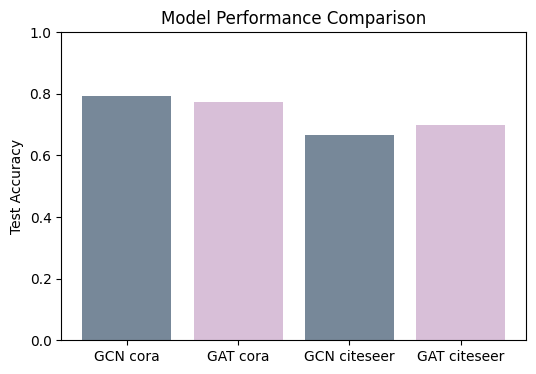

In [53]:
import matplotlib.pyplot as plt

# Compare GCN and GAT accuracy
plt.figure(figsize=(6, 4))
plt.bar(["GCN cora", "GAT cora", "GCN citeseer", "GAT citeseer"], [gcn_acc_cora[2], gat_acc_cora[2], gcn_acc_citeseer[2], gat_acc_citeseer[2]], color=['lightslategray', 'thistle'])
plt.ylabel("Test Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.show()

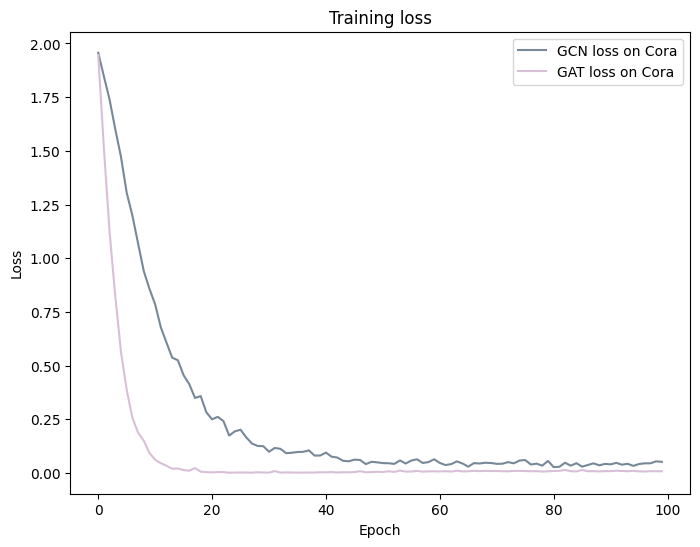

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(losses_gcn_cora, label="GCN loss on Cora", color="lightslategray")
plt.plot(losses_gat_cora, label="GAT loss on Cora", color="thistle")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()
plt.show()

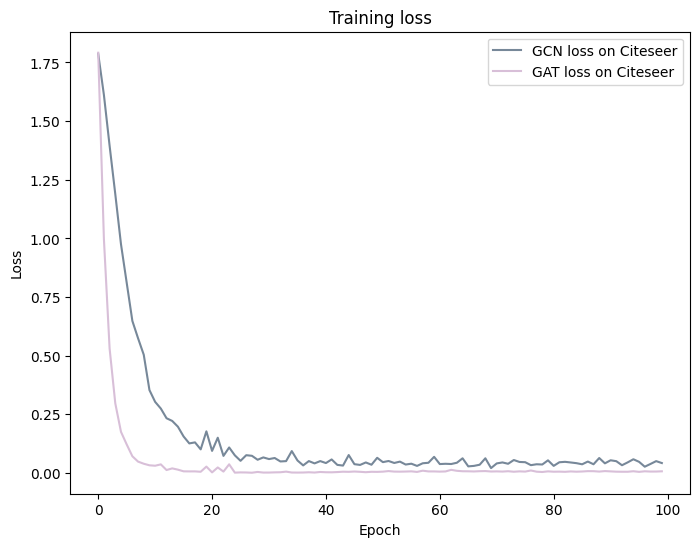

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(losses_gcn_citeseer, label="GCN loss on Citeseer", color="lightslategray")
plt.plot(losses_gat_citeseer, label="GAT loss on Citeseer", color="thistle")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()
plt.show()

## Embedding Visualization

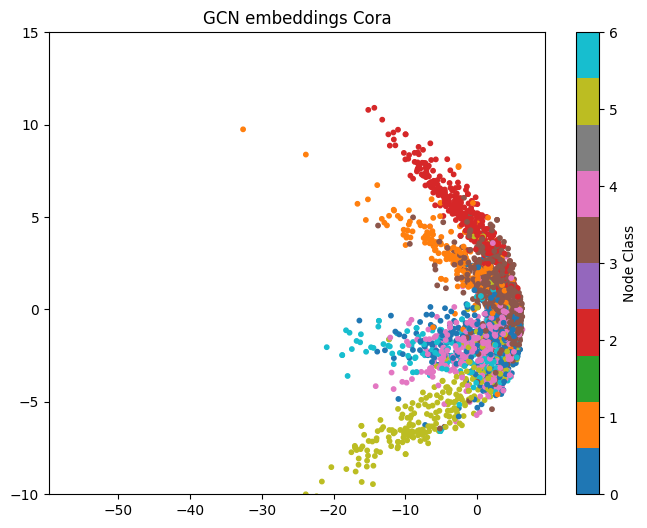

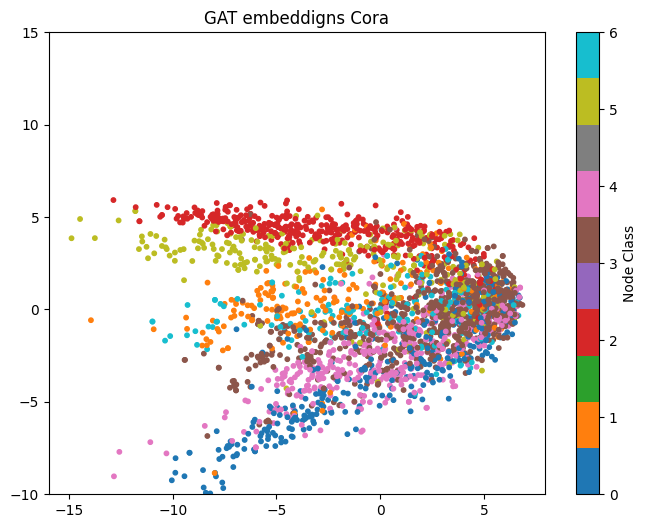

In [57]:
from sklearn.decomposition import PCA

def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        embeddings = logits.cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="tab10", s=10)
    plt.colorbar(scatter, label="Node Class")
    plt.title(title)
    plt.ylim(-10, 15)
    plt.show()

visualize_embeddings(gcn_cora, cora, "GCN embeddings Cora")
visualize_embeddings(gat_cora, cora, "GAT embeddigns Cora")


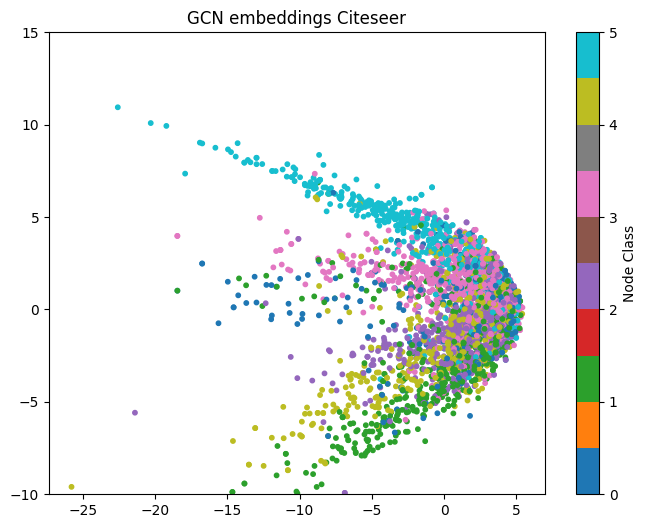

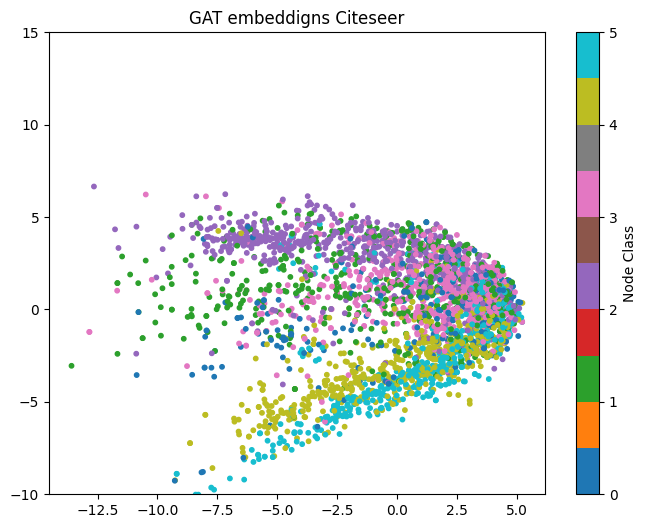

In [58]:
from sklearn.decomposition import PCA

def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        embeddings = logits.cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="tab10", s=10)
    plt.colorbar(scatter, label="Node Class")
    plt.title(title)
    plt.ylim(-10, 15)
    plt.show()

visualize_embeddings(gcn_citeseer, citeseer, "GCN embeddings Citeseer")
visualize_embeddings(gat_citeseer, citeseer, "GAT embeddigns Citeseer")
